In [1]:
# %%bash
# export SPEDAS_DATA_DIR="/mnt/d/data/pyspedas-data"
# echo $SPEDAS_DATA_DIR

In [2]:
from datetime import datetime
import string
import dateutil.parser

import asilib
import asilib.map
import asilib.asi
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import IRBEM
import cdflib
import pyspedas

import elfinasi

In [3]:
print(f'asilib version: {asilib.__version__}, elfinasi version: {elfinasi.__version__}, cdflib version: {cdflib.__version__}, pyspedas version: {pyspedas.version()}')

12-Jan-26 17:53:46: pyspedas version: 1.7.1


asilib version: 0.27.0, elfinasi version: 0.0.2, cdflib version: 0.4.9, pyspedas version: None


In [4]:
alt = 110  # km

elfin_probe = 'a'
time_range_str = ('2022-03-05T14:52', '2022-03-05T14:56')

# elfin_probe = 'b'
# time_range_str = ('2022-03-05T15:29', '2022-03-05T15:34')

# elfin_probe = 'a'
# time_range_str = ('2022-09-04T04:15', '2022-09-04T04:25')

time_range = (dateutil.parser.parse(time_range_str[0]), dateutil.parser.parse(time_range_str[1]))

In [5]:
def map_elfin(df, alt=110, hemi_flag=0):
    """
    Map ELFIN's location along the magnetic field line to alt using IRBEM.MagFields.find_foot_print.

    Parameters
    ----------
    alt: float
        The mapping altitude in units of kilometers
    hemi_flag: int
        What direction to trace the field line: 
        0 = same magnetic hemisphere as starting point
        +1   = northern magnetic hemisphere
        -1   = southern magnetic hemisphere
        +2   = opposite magnetic hemisphere as starting point
    """
    m = IRBEM.MagFields(kext='T89')
    _all = np.zeros_like(df.loc[:, ['alt', 'lat', 'lon']])

    for i, (time, row) in enumerate(df.iterrows()):
        X = {'Time':time, 'x1':row['alt'], 'x2':row['lat'], 'x3':row['lon']}
        _all[i, :] = m.find_foot_point(X, {'Kp':56}, alt, hemi_flag)['XFOOT']
    _all[_all == -1E31] = np.nan
    mapped_df = df.copy()
    mapped_df.loc[:, ['alt', 'lat', 'lon']] = _all
    return mapped_df

In [6]:
# pyspedas.projects.elfin.state(time_range_str, probe=elfin_probe.lower())

In [7]:
# pyspedas.data_quants[f'el{elfin_probe.lower()}_pos_gei'].time

In [8]:
# state = elfinasi.State(elfin_probe, time_range[0])


In [9]:
pad_obj_nflux = elfinasi.EPD_PAD(
    elfin_probe, time_range, start_pa=0, min_counts=None, accumulate=1, spin_time_tol=(2.5, 12),
    lc_exclusion_angle=0, t89=False
)

In [19]:
asi = asilib.asi.psa_project_lamp('pkf', time_range=time_range_str, alt=alt, downsample_factor=100)
color_bounds = asi.auto_color_bounds()

20220305_145200_145600_lamp_pkf_fisheye.mp4: |                          | 0%


KeyboardInterrupt: 

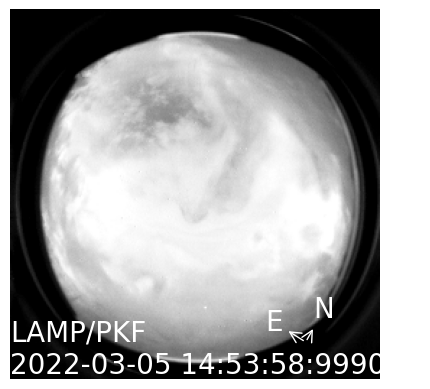

In [21]:
asi.animate_fisheye(overwrite=True, color_bounds=color_bounds)

In [13]:
transformed_state = pad_obj_nflux.transform_state()
transformed_state = transformed_state.loc[time_range[0]:time_range[1]]
mapped_state = map_elfin(transformed_state, alt=alt)

In [14]:
elfin_labels=(
    f'Omnidirectional $e^{{-}}$ number flux',
    f'$j_{{||}}/j_\\perp$ ratio',
)
plot_times = pd.date_range(time_range[0], time_range[1], periods=6)[1:-1]

In [ ]:
fig = plt.figure(figsize=(9, 7.5))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
outer_gridspec = fig.add_gridspec(
    2, 
    1,
    left=0.03, 
    right=0.95, 
    bottom=0.20, 
    top=0.97,
    hspace=0.1,
    height_ratios=(0.75, 1)
    )
top_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
    1, 
    len(plot_times), 
    subplot_spec=outer_gridspec[0, 0],
    wspace=0.02
    )
bottom_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
    len(elfin_labels), 
    10, 
    subplot_spec=outer_gridspec[1, 0], 
    hspace=0.05,
    )

ax = [
    asilib.map.create_map(
        lon_bounds=(-157, -138), 
        lat_bounds=(60, 70), 
        fig_ax=(fig, top_gs[0, i]), 
        land_color='grey'
        ) for i in range(top_gs.ncols)
    ]
bx = fig.add_subplot(bottom_gs[0, 1:])
cx = fig.add_subplot(bottom_gs[1, 1:], sharex=bx)


for time, ax_i, _label in zip(plot_times, ax, string.ascii_lowercase):
    asi[time].plot_map(
        ax=ax_i,
        min_elevation=10,
        pcolormesh_kwargs={'rasterized':True},
        asi_label=False,
        color_bounds=color_bounds
    )
    ax_i.plot(mapped_state['lon'], mapped_state['lat'], c='r', transform=ccrs.PlateCarree())

    _elfin_loc = ax_i.scatter(
        mapped_state.loc[time, 'lon'], 
        mapped_state.loc[time, 'lat'], 
        c='r', 
        s=30,
        transform=ccrs.PlateCarree(),
        label=f'ELFIN-{elfin_probe.upper()}'
        )
    if not '_legend' in locals():
        _legend = ax[0].legend(loc='lower left', ncols=2, columnspacing=0.1, handletextpad=0.1, fontsize=8)
    _plot_time = ax_i.text(
        0.01, 0.99, f'({_label}) {time:%H:%M:%S}', va='top', transform=ax_i.transAxes, fontsize=12
        )

vmin = 1E2
vmax = 5E6

p, _ = pad_obj_nflux.plot_omni(
    bx, labels=True, colorbar=False, vmin=vmin, vmax=vmax, pretty_plot=False
    )
_cbar = plt.colorbar(
    p, ax=bx, shrink=0.9, fraction=0.05, pad=0.01, ticks=np.logspace(2, 7, 6)
    )
assert pad_obj_nflux._flux_units == '#/(cm^2*s*str*MeV)'
_cbar.set_label(label=f'$[cm^2 \\ sr \\ s \\ MeV]^{{-1}}$', size=12)

p, _ = pad_obj_nflux.plot_blc_dlc_ratio(cx, labels=True, colorbar=False, vmin=1E-1, vmax=1)
# dx.contour(pad_obj_nflux.pad.time, pad_obj_nflux.energy, (pad_obj_nflux.blc/pad_obj_nflux.dlc).T, levels=[1], colors='k', linewidths=0.5)
# dx.plot(sst19_df.index, sst19_df['IBeReEnergy'], c='r', lw=5, label='SST19 IBeRe Energy')
_cbar = plt.colorbar(p, ax=cx, shrink=0.9, fraction=0.05, pad=0.01)
_cbar.set_label(label=f'$j_{{||}}/j_{{\\perp}}$', size=12)

pad_obj_nflux.plot_position(cx)
cx.xaxis.set_major_locator(plt.MaxNLocator(6))
cx.xaxis.set_label_coords(-0.09, -0.007*7)
cx.xaxis.label.set_size(9)

# Connect the subplots and add vertical lines to cx and dx.
for ax_i, image_time_numeric in zip(ax, matplotlib.dates.date2num(plot_times)):
    line = matplotlib.patches.ConnectionPatch(
        xyA=(0.5, 0), coordsA=ax_i.transAxes,
        xyB=(image_time_numeric, bx.get_ylim()[1]), coordsB=bx.transData, 
        ls='--')
    ax_i.add_artist(line)

    for _other_ax in [bx, cx]:
        _other_ax.axvline(image_time_numeric, c='k', ls='--', alpha=1)

KeyboardInterrupt: 

12-Jan-26 17:55:03: Substituting symbol \perp from STIXGeneral
12-Jan-26 17:55:03: Substituting symbol \perp from STIXGeneral
12-Jan-26 17:55:03: Substituting symbol \perp from STIXGeneral
12-Jan-26 17:55:03: Substituting symbol \perp from STIXGeneral


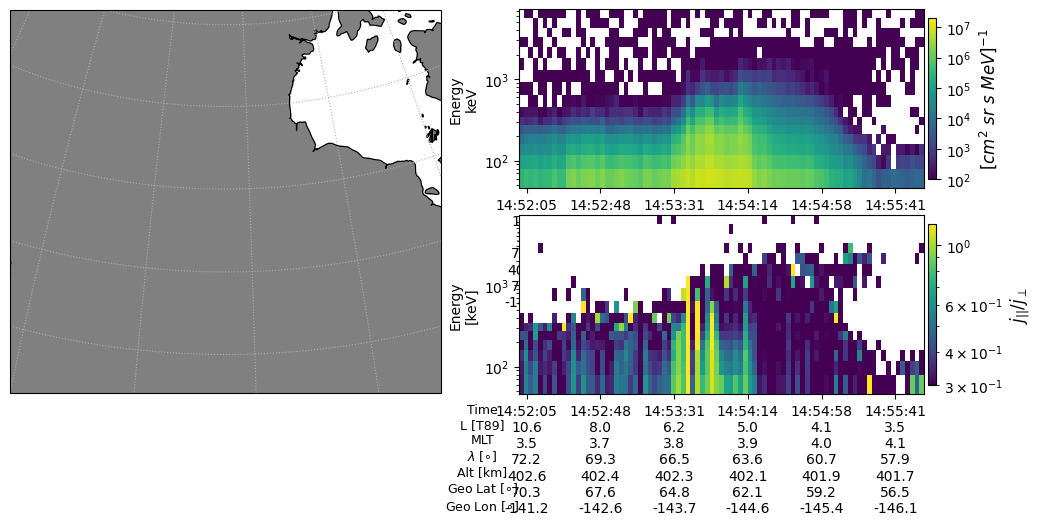

In [16]:
vmin = 1E2
vmax = 2E7

fig = plt.figure(figsize=(10, 5.5))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,
                      left=0.01, right=0.95, bottom=0.25, top=0.95,
                      wspace=0.18, hspace=0.15)
ax = asilib.map.create_map(lon_bounds=(-120, -85), lat_bounds=(41, 65), fig_ax=(fig, gs[:, 0]), land_color='grey')
bx = fig.add_subplot(gs[0, 1])
cx = fig.add_subplot(gs[1, 1], sharex=bx, sharey=bx)

p, _ = pad_obj_nflux.plot_omni(
    bx, labels=True, colorbar=False, vmin=vmin, vmax=vmax, pretty_plot=False
    )
_cbar = plt.colorbar(
    p, ax=bx, shrink=0.9, fraction=0.05, pad=0.01, ticks=np.logspace(2, 7, 6)
    )
assert pad_obj_nflux._flux_units == '#/(cm^2*s*str*MeV)'
_cbar.set_label(label=f'$[cm^2 \\ sr \\ s \\ MeV]^{{-1}}$', size=12)

p, _ = pad_obj_nflux.plot_blc_dlc_ratio(cx, labels=True, colorbar=False, vmin=3E-1, vmax=1.2)
# dx.contour(pad_obj_nflux.pad.time, pad_obj_nflux.energy, (pad_obj_nflux.blc/pad_obj_nflux.dlc).T, levels=[1], colors='k', linewidths=0.5)
# dx.plot(sst19_df.index, sst19_df['IBeReEnergy'], c='r', lw=5, label='SST19 IBeRe Energy')
_cbar = plt.colorbar(p, ax=cx, shrink=0.9, fraction=0.05, pad=0.01)
_cbar.set_label(label=f'$j_{{||}}/j_{{\\perp}}$', size=12)

pad_obj_nflux.plot_position(cx)
cx.xaxis.set_major_locator(plt.MaxNLocator(6))
cx.xaxis.set_label_coords(-0.09, -0.007*7)
cx.xaxis.label.set_size(9)